In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import matplotlib.pyplot as plt
from scipy import random
from scipy.stats import multivariate_normal


In [3]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

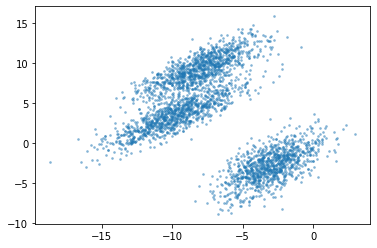

In [4]:
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [5]:
x=tf.convert_to_tensor(X,dtype=tf.float64)

In [6]:
k=3
d=x.shape[1]
n=x.shape[0]

In [7]:
x.shape

TensorShape([3000, 2])

In [183]:
pi=np.array([0.3333,0.3333,0.3333])
mu=np.array([x[6],x[100],x[46]])
sigma=np.array([[[1.0,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
z=np.zeros(shape=(n,k))


pi=tf.Variable(pi,dtype=tf.float64)
mu=tf.Variable(mu,dtype=tf.float64)
sigma=tf.Variable(sigma,dtype=tf.float64)
z=tf.Variable(z,dtype=tf.float64)

In [79]:
i=0

In [184]:
"""
previous non-vectorized version.

# E-step.
for i in range(k):
    N = tfp.distributions.MultivariateNormalFullCovariance(loc=mu[i],covariance_matrix=sigma[i]).prob(x)
    z[:, i].assign(pi[i] * N)
z.assign(z/tf.reduce_sum(z,axis=1, keepdims=True))
"""
# vectorized E-step

x_tmp=tf.expand_dims(x,axis=0) # x.shape==[n,d]
x_tmp=tf.tile(x_tmp,[k,1,1]) # x_tmp.shape==[k,n,d]

mu_tmp=tf.expand_dims(mu,axis=1) # mu.shape==[k,d]
mu_tmp=tf.tile(mu_tmp,[1,n,1])   # mu_tmp.shape==[k,n,d]

sig_tmp=tf.expand_dims(sigma,axis=1) # sigma.shape==[k,d,d]
sig_tmp=tf.tile(sig_tmp,[1,n,1,1])   # sig_tmp.shape == [k,n,d,d]

N = tfp.distributions.MultivariateNormalFullCovariance(loc=mu_tmp,covariance_matrix=sig_tmp).prob(x_tmp)
# N.shape==[k,n]
N=tf.transpose(N) # N.shape == [n,k]
#N.shape

z=pi*N 
z=z/tf.expand_dims(tf.reduce_sum(z,axis=1),axis=1)

In [162]:
z

<tf.Tensor: shape=(3000, 3), dtype=float64, numpy=
array([[3.18978574e-01, 4.65156504e-01, 2.15864922e-01],
       [3.73481307e-01, 3.04863704e-01, 3.21654989e-01],
       [2.36098439e-01, 6.40539544e-01, 1.23362017e-01],
       ...,
       [6.93335828e-04, 9.99279523e-01, 2.71413648e-05],
       [5.25194193e-05, 9.99946780e-01, 7.00789524e-07],
       [7.56428554e-04, 9.99212875e-01, 3.06969342e-05]])>

In [185]:
""" Vectorized M-step"""

N_k=tf.reduce_sum(z,axis=0)
pi=N_k/n
mu = tf.matmul(tf.transpose(z),x)
mu=mu/N_k[:,None]

#print(x.shape,x_tmp.shape)

mu_tmp=tf.expand_dims(mu,axis=1)
mu_tmp=tf.tile(mu_tmp,[1,n,1])

x_tmp=x_tmp-mu_tmp
x_tmp=tf.reshape(x_tmp,[k,n,d,1])
x_tmp_T=tf.transpose(x_tmp,perm=[0,1,3,2])
res=tf.matmul(x_tmp,x_tmp_T)
#res.shape

z_T=tf.transpose(z)
#z_T.shape
res=tf.multiply(tf.reshape(z_T,[k,n,1,1]),res)
#res.shape
sigma=tf.reduce_sum(res,axis=1)/tf.reshape(N_k,[k,1,1])

In [186]:
sigma

<tf.Tensor: shape=(3, 2, 2), dtype=float64, numpy=
array([[[ 5.00825037,  6.34427071],
        [ 6.34427071, 13.17371099]],

       [[ 8.64404821, -6.40101083],
        [-6.40101083, 27.23764724]],

       [[ 5.23483302,  6.62802635],
        [ 6.62802635, 13.23050805]]])>

In [179]:
"""
previous non-vectorized version.

# M-step
N_k=tf.reduce_sum(z,axis=0) 
pi=N_k/n 
mu = tf.matmul(tf.transpose(z),x)
mu=mu/N_k[:,None]

for i in range(k):
    tmp=x-mu[i] #
    tmp=tf.reshape(tmp,[n,d,1])
    tmp_T=tf.transpose(tmp,perm=[0,2,1])
    res=tf.matmul(tmp,tmp_T)
    res=tf.multiply(tf.reshape(z[:,i],[n,1,1]),res)
    res=tf.reduce_sum(res,axis=0)/N_k[i]
    sigma[i].assign(res)

"""

In [180]:
sigma

<tf.Variable 'Variable:0' shape=(3, 2, 2) dtype=float64, numpy=
array([[[ 5.00825037,  6.34427071],
        [ 6.34427071, 13.17371099]],

       [[ 8.64404821, -6.40101083],
        [-6.40101083, 27.23764724]],

       [[ 5.23483302,  6.62802635],
        [ 6.62802635, 13.23050805]]])>